<a href="https://colab.research.google.com/github/tanuja1708/EEG-emotions/blob/main/new%20bandpass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flask
!npm install -g localtunnel
!pip install flask flask-ngrok tensorflow joblib pykalman scipy
!pip install PyWavelets

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼
added 22 packages in 3s
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼Requirement already satisfied: flask in /usr/local/lib/python3.11/dist-packages (3.1.1)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 8.8 MB/s eta 0:00:00


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


your url is: https://eegemotion.loca.lt


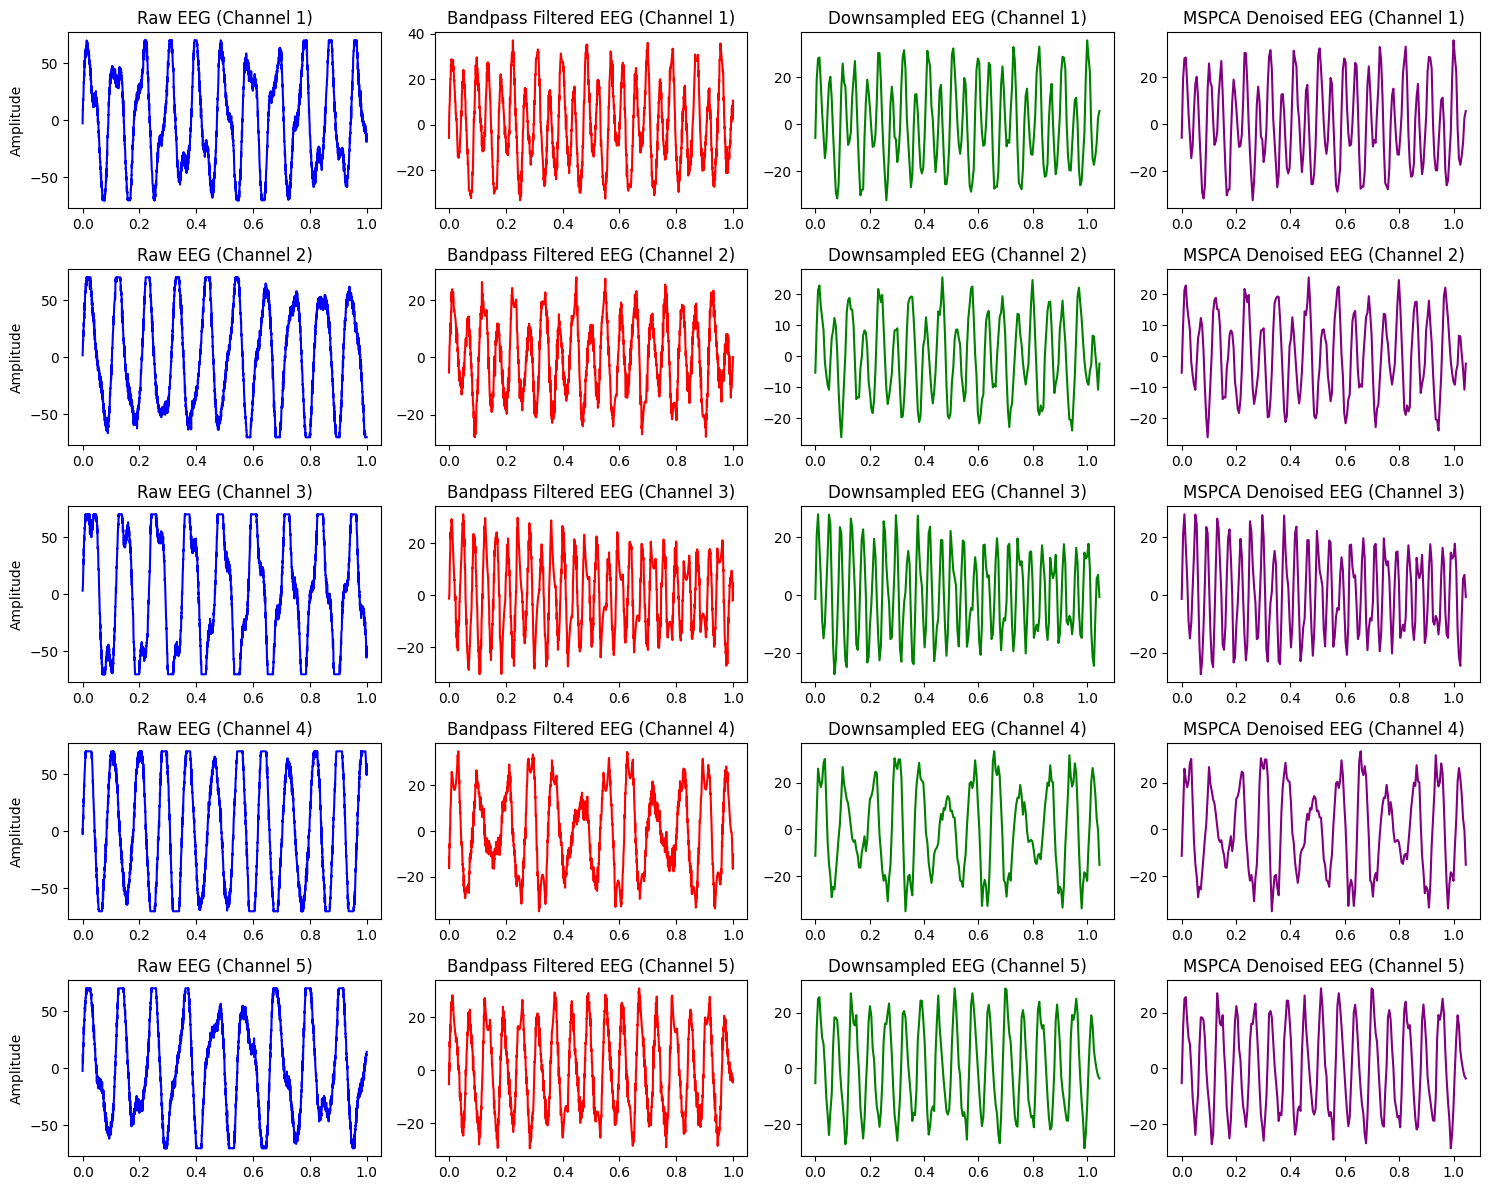

ERROR:__main__:Exception on /predict [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 919, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 902, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-2-6c325777aaa9>", line 180, in predict
    sample = extract_de_lds(mspca_eeg).reshape((1, 1.310))
         

In [ ]:
from flask import Flask, jsonify
import numpy as np
from scipy.signal import butter, filtfilt, welch
from pykalman import KalmanFilter
from tensorflow.keras.models import load_model
import joblib
import pywt
from sklearn.decomposition import PCA
import subprocess
from threading import Thread
import matplotlib.pyplot as plt

app = Flask(__name__)

# --- EEG Config ---
sampling_rate_original = 2500
sampling_rate_final = 200
segment_length = sampling_rate_final * 1

freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 14),
    "Beta": (14, 31),
    "Gamma": (31, 50)
}

# --- Kalman Filter Setup ---
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    transition_covariance=0.2 * np.eye(1),
    observation_covariance=0.5 * np.eye(1),
    initial_state_mean=[20],
    initial_state_covariance=5 * np.eye(1)
)

# --- Filtering & Downsampling ---
def bandpass_filter(data, lowcut, highcut, fs):
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data)

def downsample(signal, original_fs, target_fs):
    factor = int(original_fs / target_fs)
    return signal[::factor]

# --- EEG Generator ---
def generate_eeg():
    t = np.linspace(0, 1, sampling_rate_original)
    eeg = []
    for _ in range(62):
        alpha = np.random.uniform(40, 80) * np.sin(2 * np.pi * np.random.uniform(8, 13) * t)
        beta = np.random.uniform(15, 35) * np.sin(2 * np.pi * np.random.uniform(14, 30) * t)
        delta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(1, 3) * t)
        theta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(4, 7) * t)
        gamma = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(31, 50) * t)
        noise = np.random.normal(0, 3, t.shape)
        signal = delta + theta + alpha + beta + gamma + noise
        eeg.append(np.clip(signal, -70, 70))
    return np.array(eeg)

# --- MSPCA Denoising ---
def mspca_denoise(eeg_data, wavelet='db4', level=4):
    denoised_eeg = []
    for channel in eeg_data:
        coeffs = pywt.wavedec(channel, wavelet, level=level)
        denoised_coeffs = []
        for c in coeffs:
            if len(c) > 1:
                c = c.reshape(-1, 1)
                pca = PCA(n_components=1)
                transformed = pca.fit_transform(c)
                reconstructed = pca.inverse_transform(transformed).flatten()
                denoised_coeffs.append(reconstructed)
            else:
                denoised_coeffs.append(c)
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
        denoised_eeg.append(denoised_signal[:len(channel)])
    return np.array(denoised_eeg)

# --- DE_LDS with Welch & MSPCA ---
def extract_de_lds(eeg_data):
    # eeg_data = [bandpass_filter(ch, 1, 50, sampling_rate_final) for ch in eeg_data]
    # eeg_data = [downsample(ch, sampling_rate_original, sampling_rate_final) for ch in eeg_data]
    # eeg_data = mspca_denoise(np.array(eeg_data))

    de_features = []
    for ch_data in eeg_data:
        freqs, psd = welch(ch_data, fs=sampling_rate_final, nperseg=min(200, segment_length))
        band_de = []
        for _, (low, high) in freq_bands.items():
            band_power = psd[(freqs >= low) & (freqs <= high)]
            band_de_value = 0.5 * np.log(2 * np.pi * np.e * (np.mean(band_power) + 1e-6))
            band_de.append(band_de_value)
        smoothed_de, _ = kf.filter(np.array(band_de).reshape(-1, 1))
        de_features.append(smoothed_de.flatten())
    de_features = np.array(de_features)

    # Normalize
    de_min, de_max = np.min(de_features), np.max(de_features)
    scaled = 15 + (de_features - de_min) / (de_max - de_min + 1e-8) * (27 - 15)
    return scaled.flatten()

# --- Plotting Function ---
# def plot_eeg_signals(raw_eeg, bandpassed_eeg, downsampled_eeg, mspca_eeg, channels=5):
#     fig, axs = plt.subplots(channels, 4, figsize=(15, 12))

#     for i in range(channels):
#         # Raw EEG
#         axs[i, 0].plot(raw_eeg[i], color='b')
#         axs[i, 0].set_title(f'Raw EEG (Channel {i+1})')
#         axs[i, 0].set_ylabel('Amplitude')

#         # Bandpass Filtered EEG
#         axs[i, 1].plot(bandpassed_eeg[i], color='r')
#         axs[i, 1].set_title(f'Bandpass Filtered EEG (Channel {i+1})')

#          # Downsampled EEG
#         axs[i, 2].plot(downsampled_eeg[i], color='g')
#         axs[i, 2].set_title(f'Downsampled EEG (Channel {i+1})')

#         # MSPCA Denoised EEG
#         axs[i, 3].plot(mspca_eeg[i], color='purple')
#         axs[i, 3].set_title(f'MSPCA Denoised EEG (Channel {i+1})')

#     plt.tight_layout()
#     plt.show()

def plot_eeg_signals(raw_eeg, bandpassed_eeg, downsampled_eeg, mspca_eeg, channels=5):
    fig, axs = plt.subplots(channels, 4, figsize=(15, 12))

    duration_raw = len(raw_eeg[0]) / sampling_rate_original
    duration_down = len(downsampled_eeg[0]) / sampling_rate_final

    t_raw = np.linspace(0, duration_raw, len(raw_eeg[0]))
    t_down = np.linspace(0, duration_down, len(downsampled_eeg[0]))

    for i in range(channels):
        # Raw EEG
        axs[i, 0].plot(t_raw, raw_eeg[i], color='b')
        axs[i, 0].set_title(f'Raw EEG (Channel {i+1})')
        axs[i, 0].set_ylabel('Amplitude')

        # Bandpass Filtered EEG
        axs[i, 1].plot(t_raw, bandpassed_eeg[i], color='r')
        axs[i, 1].set_title(f'Bandpass Filtered EEG (Channel {i+1})')

        # Downsampled EEG
        axs[i, 2].plot(t_down, downsampled_eeg[i], color='g')
        axs[i, 2].set_title(f'Downsampled EEG (Channel {i+1})')

        # MSPCA Denoised EEG
        axs[i, 3].plot(t_down, mspca_eeg[i], color='purple')
        axs[i, 3].set_title(f'MSPCA Denoised EEG (Channel {i+1})')

    plt.tight_layout()
    plt.show()

# --- API Route ---
@app.route('/predict', methods=['GET'])
def predict():
    eeg_data = generate_eeg()

     # Bandpass Filter
    bandpassed_eeg = [bandpass_filter(ch, 1, 50, sampling_rate_final) for ch in eeg_data]

    # Downsample
    downsampled_eeg = [downsample(ch, sampling_rate_original, sampling_rate_final) for ch in bandpassed_eeg]



    # MSPCA Denoising
    mspca_eeg = mspca_denoise(np.array(downsampled_eeg))

    # Plot the signals
    plot_eeg_signals(eeg_data, bandpassed_eeg, downsampled_eeg,mspca_eeg)

    # Extract features for model prediction
    sample = extract_de_lds(mspca_eeg).reshape((1, 1.310))

    model = load_model('/content/eeg_emotion_gan_model.h5')
    encoder = joblib.load('/content/eeg_label_encoder.pkl')
    prediction = model.predict(sample)
    label = encoder.inverse_transform(np.argmax(prediction, axis=1))[0]

    print(f"Predicted Emotion: {label}")
    return jsonify({'emotion': label, 'eeg_data': eeg_data.tolist()})

# --- LocalTunnel Setup ---
def run_localtunnel():
    subdomain = "eegemotion"
    process = subprocess.Popen(['lt', '--port', '5000', '-s', subdomain], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode('utf-8').strip())

# --- Run App ---
if __name__ == "__main__":
    from threading import Thread
    # Run LocalTunnel in a separate thread
    thread = Thread(target=run_localtunnel)
    thread.start()
    app.run(port=5000)


In [ ]:
!pip install numpy scipy PyWavelets
!pip install scikit-learn filterpy tensorflow joblib


In [7]:
#with bandpass with ui

from flask import Flask, jsonify
import numpy as np
from tensorflow.keras.models import load_model
import joblib
from scipy.signal import butter, filtfilt,welch
from pykalman import KalmanFilter
import subprocess
import pywt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

app = Flask(__name__)

sampling_rate_original = 2500
sampling_rate_final = 200
segment_length = sampling_rate_final * 1

freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 14),
    "Beta": (14, 31),
    "Gamma": (31, 50)
}

# --- Kalman Filter Setup ---
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    transition_covariance=0.2 * np.eye(1),
    observation_covariance=0.5 * np.eye(1),
    initial_state_mean=[20],
    initial_state_covariance=5 * np.eye(1)
)

# --- Filtering & Downsampling ---
def bandpass_filter(data, lowcut, highcut, fs):
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data)

def downsample(signal, original_fs, target_fs):
    factor = int(original_fs / target_fs)
    return signal[::factor]

# --- EEG Generator ---
def generate_eeg():
    t = np.linspace(0, 1, sampling_rate_original)
    eeg = []
    for _ in range(62):
        alpha = np.random.uniform(40, 80) * np.sin(2 * np.pi * np.random.uniform(8, 13) * t)
        beta = np.random.uniform(15, 35) * np.sin(2 * np.pi * np.random.uniform(14, 30) * t)
        delta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(1, 3) * t)
        theta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(4, 7) * t)
        gamma = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(31, 50) * t)
        noise = np.random.normal(0, 3, t.shape)
        signal = delta + theta + alpha + beta + gamma + noise
        eeg.append(np.clip(signal, -70, 70))
    return np.array(eeg)

# --- MSPCA Denoising ---
def mspca_denoise(eeg_data, wavelet='db4', level=4):
    denoised_eeg = []
    for channel in eeg_data:
        coeffs = pywt.wavedec(channel, wavelet, level=level)
        denoised_coeffs = []
        for c in coeffs:
            if len(c) > 1:
                c = c.reshape(-1, 1)
                pca = PCA(n_components=1)
                transformed = pca.fit_transform(c)
                reconstructed = pca.inverse_transform(transformed).flatten()
                denoised_coeffs.append(reconstructed)
            else:
                denoised_coeffs.append(c)
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
        denoised_eeg.append(denoised_signal[:len(channel)])
    return np.array(denoised_eeg)

# --- DE_LDS with Band-Split, Welch & MSPCA ---
def extract_de_lds(eeg_data):
    # 1) Downsample all channels
    eeg_ds = [downsample(ch, sampling_rate_original, sampling_rate_final)
              for ch in eeg_data]

    de_features = []  # will become list of 62 vectors of length 5
    for ch in eeg_ds:
        channel_de = []

        for low, high in freq_bands.values():
            # 2) Narrow-band filter
            sig_band = bandpass_filter(ch, low, high, sampling_rate_final)


            # 3) MSPCA denoise _this_ 1D signal
            denoised = mspca_denoise([sig_band])[0]

            # 4) PSD → DE
            freqs, psd = welch(denoised, fs=sampling_rate_final,
                               nperseg=min(100, segment_length))
            P_mean = np.mean(psd)
            de_val = 0.5 * np.log(2 * np.pi * np.e * (P_mean + 1e-6))
            channel_de.append(de_val)

        # 5) Kalman smooth the 5-band DE vector
        smoothed, _ = kf.filter(np.array(channel_de).reshape(-1, 1))
        de_features.append(smoothed.flatten())

    # 6) Normalize & flatten
    feats = np.array(de_features)            # shape (62,5)
    mn, mx = feats.min(), feats.max()
    scaled = 15 + (feats - mn) / (mx - mn + 1e-8) * (27 - 15)
    # print(scaled.flatten())
    return scaled.flatten()

@app.route('/predict', methods=['GET'])
def predict_emotion():
    eeg_data = generate_eeg()
    features = extract_de_lds(eeg_data).reshape((1, 1,310))

    # Load model and encoder
    model = load_model('/content/eeg_emotion_gan_model.h5')
    encoder = joblib.load('/content/eeg_label_encoder.pkl')

    prediction = model.predict(features)
    label = encoder.inverse_transform(np.argmax(prediction, axis=1))[0]

    print(f"Predicted Emotion: {label}")
    return jsonify({'emotion': label, 'eeg_data': eeg_data.tolist()})

# --- LocalTunnel Setup ---
def run_localtunnel():
    subdomain = "eegemotion"
    process = subprocess.Popen(['lt', '--port', '5000', '-s', subdomain], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode('utf-8').strip())

# --- Run App ---
if __name__ == "__main__":
    from threading import Thread
    thread = Thread(target=run_localtunnel)
    thread.start()
    app.run(port=5000)



 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


your url is: https://eegemotion.loca.lt


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


INFO:werkzeug:127.0.0.1 - - [15/May/2025 20:08:35] "GET /predict HTTP/1.1" 200 -


Predicted Emotion: Happy


In [31]:
from flask import Flask, jsonify
import numpy as np
from tensorflow.keras.models import load_model
import joblib
from scipy.signal import butter, filtfilt, welch
from pykalman import KalmanFilter
import subprocess
import pywt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from threading import Thread

app = Flask(__name__)

# Constants
sampling_rate_original = 2500
sampling_rate_final = 200
segment_length = sampling_rate_final * 1

freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 14),
    "Beta": (14, 31),
    "Gamma": (31, 50)
}

kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    transition_covariance=0.2 * np.eye(1),
    observation_covariance=0.5 * np.eye(1),
    initial_state_mean=[20],
    initial_state_covariance=5 * np.eye(1)
)

# Functions

def bandpass_filter(data, lowcut, highcut, fs):
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data)

def downsample(signal, original_fs, target_fs):
    factor = int(original_fs / target_fs)
    return signal[::factor]

def generate_eeg():
    t = np.linspace(0, 1, sampling_rate_original)
    eeg = []
    for _ in range(62):
        alpha = np.random.uniform(40, 80) * np.sin(2 * np.pi * np.random.uniform(8, 13) * t)
        beta = np.random.uniform(15, 35) * np.sin(2 * np.pi * np.random.uniform(14, 30) * t)
        delta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(1, 3) * t)
        theta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(4, 7) * t)
        gamma = np.random.normal(0, 3, t.shape)
        signal = delta + theta + alpha + beta + gamma
        eeg.append(np.clip(signal, -70, 70))
    return np.array(eeg)

def mspca_denoise(eeg_data, wavelet='db4', level=4):
    denoised_eeg = []
    for channel in eeg_data:
        coeffs = pywt.wavedec(channel, wavelet, level=level)
        denoised_coeffs = []
        for c in coeffs:
            if len(c) > 1:
                c = c.reshape(-1, 1)
                pca = PCA(n_components=1)
                transformed = pca.fit_transform(c)
                reconstructed = pca.inverse_transform(transformed).flatten()
                denoised_coeffs.append(reconstructed)
            else:
                denoised_coeffs.append(c)
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
        denoised_eeg.append(denoised_signal[:len(channel)])
    return np.array(denoised_eeg)

def extract_de_lds(eeg_data):
    eeg_ds = [downsample(ch, sampling_rate_original, sampling_rate_final) for ch in eeg_data]
    de_features = []
    for ch in eeg_ds:
        channel_de = []
        for low, high in freq_bands.values():
            sig_band = bandpass_filter(ch, low, high, sampling_rate_final)
            denoised = mspca_denoise([sig_band])[0]
            freqs, psd = welch(denoised, fs=sampling_rate_final, nperseg=min(200, segment_length))
            P_mean = np.mean(psd)
            de_val = 0.5 * np.log(2 * np.pi * np.e * (P_mean + 1e-6))
            channel_de.append(de_val)
        smoothed, _ = kf.filter(np.array(channel_de).reshape(-1, 1))
        de_features.append(smoothed.flatten())
    feats = np.array(de_features)
    mn, mx = feats.min(), feats.max()
    scaled = 15 + (feats - mn) / (mx - mn + 1e-8) * (27 - 15)
    return scaled.flatten()

def plot_all_bands(raw, fs_raw, fs_ds):
    down = downsample(raw, fs_raw, fs_ds)
    plt.figure(figsize=(16, 30))

    i = 1

    # Raw EEG
    plt.subplot(12, 1, i)
    plt.plot(np.linspace(0, len(raw)/fs_raw, len(raw)), raw)
    plt.title("Raw EEG Signal (Channel 0)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    i += 1

    # Downsampled EEG
    plt.subplot(12, 1, i)
    plt.plot(np.linspace(0, len(down)/fs_ds, len(down)), down)
    plt.title("Downsampled EEG Signal (Channel 0)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    i += 1

    for band, (low, high) in freq_bands.items():
        bandpassed = bandpass_filter(down, low, high, fs_ds)
        plt.subplot(12, 1, i)
        plt.plot(np.linspace(0, len(bandpassed)/fs_ds, len(bandpassed)), bandpassed)
        plt.title(f"{band} Band (Bandpass Only)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        i += 1

        denoised = mspca_denoise([bandpassed])[0]
        plt.subplot(12, 1, i)
        plt.plot(np.linspace(0, len(denoised)/fs_ds, len(denoised)), denoised)
        plt.title(f"{band} Band after MSPCA")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        i += 1

    plt.tight_layout()
    plt.savefig("eeg_band_processing.png")  # Or use plt.show() for GUI
    plt.close()

@app.route('/predict', methods=['GET'])
def predict_emotion():
    eeg_data = generate_eeg()
    features = extract_de_lds(eeg_data).reshape((1, 1, 310))

    model = load_model('eeg_emotion_gan_model.h5')  # Use relative path
    encoder = joblib.load('eeg_label_encoder.pkl')  # Use relative path

    prediction = model.predict(features)
    label = encoder.inverse_transform(np.argmax(prediction, axis=1))[0]

    print(f"Predicted Emotion: {label}")

    # Plot EEG stages for channel 0
    plot_all_bands(eeg_data[0], sampling_rate_original, sampling_rate_final)

    return jsonify({'emotion': label, 'eeg_data': eeg_data.tolist()})

def run_localtunnel():
    subdomain = "eegemotion"
    process = subprocess.Popen(['lt', '--port', '5000', '-s', subdomain], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode('utf-8').strip())

if __name__ == "__main__":
    thread = Thread(target=run_localtunnel)
    thread.start()
    app.run(port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


your url is: https://eegemotion.loca.lt


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Predicted Emotion: Anger


INFO:werkzeug:127.0.0.1 - - [15/May/2025 15:17:46] "GET /predict HTTP/1.1" 200 -


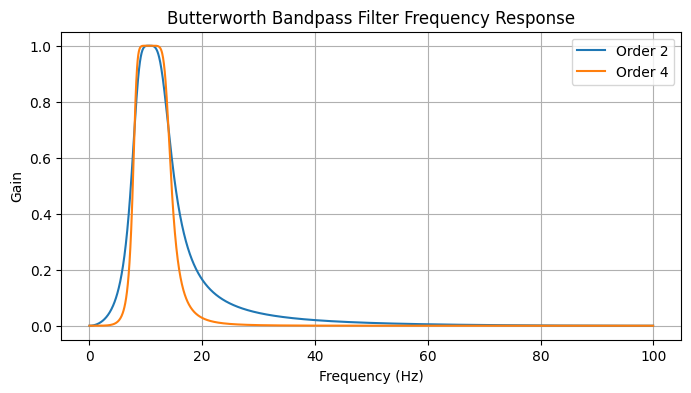

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz

def plot_butterworth(order, lowcut, highcut, fs):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')

    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label=f'Order {order}')

fs = 200  # Sampling frequency
lowcut = 8  # 8 Hz (Alpha band start)
highcut = 14  # 14 Hz (Alpha band end)

plt.figure(figsize=(8, 4))
plot_butterworth(2, lowcut, highcut, fs)
plot_butterworth(4, lowcut, highcut, fs)

plt.title('Butterworth Bandpass Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.legend()
plt.grid(True)
plt.show()
